In [1]:
import requests, time, pickle, os
import CF_standard_functions as cf_sf # Standard utility functions
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Set these parameters for saving and loading data
output_dir = os.getcwd()
file_name = 'CardData.pkl'
full_file = output_dir+"\\"+file_name

## Get Card Data from Scryfall using the Scryfall API
**Scryfall** is a powerful database and search engin for Magic: The Gathering cards. 
We will use their API to download all cards that have flavor text. Since cards are often reprinted with different flavor text each time, we will import all printed versions of every card that _does_ contain flavor text. 

https://scryfall.com/docs/api

We then convert the data to a pandas dataframe and isolate unique instances of flavor text. Finally we will save a local copy of the data so that we don't have to access the API repeatedly. New cards are only added monthly or so. 



In [3]:
# Scryfall query parameters:
order = "cmc"
# Unique printings of cards that have flavor text, English prints only, and ignoring "funny" cards (like those from the un-sets or holiday cards)
querystring = "has%3Aflavor+unique%3Aprints+%2Dis%3Dfunny+language%3Den&unique=prints"
url = f"https://api.scryfall.com/cards/search?order={order}&q={querystring}"

# First check if data already exists and is "fresh". If so, load it in:
# Here defining fresh as newer than a week
if os.path.isfile(full_file) and cf_sf.file_age_in_hours(full_file) < 24*3 :
    print('Loading data from disk...')
    file = open(full_file, 'rb')
    data = pickle.load(file)
    file.close()
    print('Done!')
else:# Otherwise get the data from Scryfall. This can take a while... 
    sf_response = requests.get(url).json()
    data = sf_response['data']
    curr_page = 1;
    print(f"Page {curr_page}",end='\r')
    while sf_response['has_more']:  
        time.sleep(0.2) # Be polite and patient with the API
        url_next = sf_response['next_page']
        sf_response = requests.get(url_next).json()
        data_new = sf_response['data']
        data = data + data_new
        curr_page += 1 
        print(f"Page {curr_page}",end='\r')
    
    print(f"Loaded {curr_page} pages of cards")
    print("Saving...")
    data = pd.DataFrame(data)
    data.drop_duplicates(subset='flavor_text',inplace=True)
    file = open(full_file,'wb')    
    pickle.dump(data, file)
    file.close()
    print("Done!")
    
nCards = len(data)
print(nCards,"cards in data set")

Loading data from disk...
Done!
20546 cards in data set


### Organize cards by color
In our first task we will classify flavor text by color. For convenience, we will make a new dataframe subsetting only the name, flavortext, and color of monocolored cards.\
To make separating cards by colors easier, we add a Boolean variable to the dataframe for each color.\
We also add a Boolean for whether or not a card is monocolored (not colorless and not multicolored). \
Finally, sort our cards in traditional WUBRG (**W**hite, Bl**u**E, **B**lack, **R**ed, **G**reen) order by setting the _colors_ variable to a categorical value.


In [4]:
data = pd.DataFrame(data)
data.drop_duplicates(subset='flavor_text',inplace=True)

for c in ['W','U','B','R','G']:
    tf = data.colors.apply(lambda x : np.shape(x) != (0,) and np.any(np.isin(x,c)))
    data['is_'+c] = tf

tf = np.sum(data.loc[:][['is_W','is_U','is_B','is_R','is_G']],axis=1) == 1
data['is_monocolor'] = tf

data_monocolor = data.loc[data.is_monocolor][['name','colors','flavor_text']].copy()
data_monocolor['colors'] = data_monocolor.colors.apply(lambda x: ''.join(x)) # Convert from list to string

data_monocolor['colors'] = pd.Categorical(data_monocolor['colors'],ordered=True)
data_monocolor['colors'] = data_monocolor['colors'].cat.reorder_categories(['W','U','B','R','G'])
data_monocolor.sort_values('colors',ascending=True,inplace=True)
data_monocolor
#print(f"Post-trimming: {data_monocolor.shape[0]} unique instances of flavor text on monocolor cards")

C:\Users\gordo\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,colors,flavor_text
14283,Squire,W,"""Of twenty yeer of age he was, I gesse.\nOf hi..."
34523,Miraculous Recovery,W,"""You stop breathing for just a few minutes and..."
10950,Kami of Ancient Law,W,"""Duty and law are the foundation on which civi..."
10933,Justiciar's Portal,W,"With the new guildmaster's innovations, arrest..."
10923,Juniper Order Rootweaver,W,"""What Phyrexia takes, the grace of Freyalise s..."
...,...,...,...
20088,Hungry Spriggan,G,If a spriggan's eyes are larger than its stoma...
34455,Meandering Towershell,G,The wait is proportional to the weight.
11145,Kraul Warrior,G,The insectile kraul lurk in the tunnels below ...
20093,Hunter's Ambush,G,First you lose your enemy's trail. Then you lo...


### Prepare data for classification

For our classifier we need numeric groups, so we will make numeric categories for the colors.

In [21]:
label_map = {'W':0,
             'U':1,
             'B':2,
             'R':3,
             'G':4}
data_monocolor['label'] = data_monocolor['colors'].map(label_map)
data_monocolor.sample(5)

,name,colors,flavor_text,label
2922,Coming In Hot,R,"""I have a reckless idea,"" Koth offered. Chandr...",3
15375,Vedalken Mastermind,U,The vedalken see other beings from a cold dist...,1
14098,Soldevi Sage,U,"""To hide the truth is more than folly—it is fa...",1
6231,Surge of Zeal,R,"""If only my poxes were as infectious as their ...",3
29721,Novice Dissector,B,"""The professor said to first extract the venom...",2


### Split data into train and test sets

In [22]:
from sklearn.model_selection import train_test_split

flavor_train, flavor_test, label_train, label_test = train_test_split(
        data_monocolor['flavor_text'], data_monocolor['label'], test_size=0.25, random_state=1)

print('Training set consists of',flavor_train.shape[0],'cards.')
print('Test set consists of',flavor_test.shape[0],'cards.')


Training set consists of 12005 cards.
Test set consists of 4002 cards.


## Design our Model!
- Tokenize the words in flavor text, ignoring terms that are extremeley common and those that only appear 3 or fewer times in the training set.
- Classify the text using an SVM.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
my_vectorizer = TfidfVectorizer(max_df = 0.95 , min_df = 3)
pipe = Pipeline([('vect',my_vectorizer),
               ('clf',LinearSVC())])

pipe.fit(X=flavor_train,y=label_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.95, min_df=3)),
                ('clf', LinearSVC())])

In [24]:
label_predict = pipe.predict(flavor_test)
performance = np.round(sum(label_predict == label_test) / len(label_test) , 3)*100
print('Classifier hit rate is %s%%' % performance)


Classifier hit rate is 50.6%


**Measure performance with a confusion matrix:**

              precision    recall  f1-score   support

           W       0.48      0.50      0.49       847
           U       0.47      0.53      0.50       729
           B       0.50      0.52      0.51       773
           R       0.55      0.49      0.52       851
           G       0.53      0.50      0.51       802

    accuracy                           0.51      4002
   macro avg       0.51      0.51      0.51      4002
weighted avg       0.51      0.51      0.51      4002



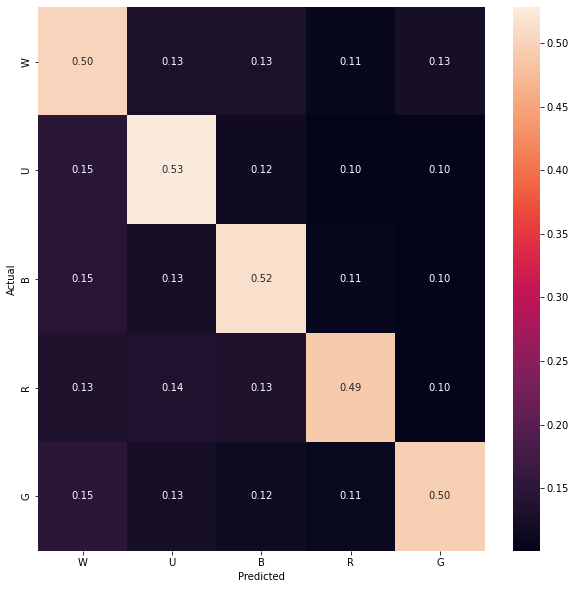

In [60]:
from sklearn import metrics
import seaborn as sns

print(metrics.classification_report(label_test, label_predict,target_names = [str(i) for i in label_map]))

cm = metrics.confusion_matrix(label_test, label_predict,normalize='true',
                              labels=list(label_map.values()))

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=[str(i) for i in label_map],yticklabels=[str(i) for i in label_map])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


**Not too shabby!** \
We can now write our own flavor text and see what color our model thinks it belongs to.

In [64]:
new_flavor_text = ['Goblins sure do smell bad',
              'Your spell was a mistake and now it is gone',
              'Trees are the most beautiful thing',
              'Death cannot stop the wicked',
              'The angelic choir sings loftily over the clouds',
              '"Some like it hot" -Chandra Nalaar']

new_color_predictions = pipe.predict(new_flavor_text)
# Reverse-lookup color mapping    
for txt,col in zip(new_flavor_text,new_color_predictions):
    print(f"{txt} --> {[str(i) for i in label_map][col]}")

Goblins sure do smell bad --> R
Your spell was a mistake and now it is gone --> U
Trees are the most beautiful thing --> G
Death cannot stop the wicked --> B
The angelic choir sings loftily over the clouds --> W
"Some like it hot" -Chandra Nalaar --> R


**Lets see if we can do better by tokenizing word pairs as well as individual words**

In [68]:
performance = np.round(sum(label_predict == label_test) / len(label_test) , 3)*100
print('Classifier hit rate is %s%%' % performance)
pipe.set_params(vect__ngram_range = (1,2))
pipe.fit(flavor_train,label_train)
color_predict = pipe.predict(flavor_test)
print(metrics.classification_report(label_test, label_predict,
                                    target_names=[str(i) for i in label_map]))


Classifier hit rate is 50.6%
              precision    recall  f1-score   support

           W       0.48      0.50      0.49       847
           U       0.47      0.53      0.50       729
           B       0.50      0.52      0.51       773
           R       0.55      0.49      0.52       851
           G       0.53      0.50      0.51       802

    accuracy                           0.51      4002
   macro avg       0.51      0.51      0.51      4002
weighted avg       0.51      0.51      0.51      4002

